# Generation of qualitative results

Weights-based explanations obtained from the suggested model are visually compared to the explanations extracted from unwrapp LLM and the saliency maps obtained with CAM. In the case of weights-based explanations, we create a saliency map multiplying each weight with its corresponding input element. Bearing in mind that the output logits of the model are defined as:

$z^{(i)} = \sum^{M}_{m=0}\sum ^{T}_{t=0} w^{(i)}_{t,m} x^{(i)}_{t,m}  + b^{(i)}$

where $b^{(i)}$ and $w^{i}_{t,m}$ are the unwrapped weight and bias for the $i$-th sample in the $t$-th time step and the $m$-th feature, the set of values 
$\{w^{(i)}_{t,m} x^{(i)}_{t,m} + \frac{b^{(i)}}{TM}\} \quad t=1,2, \dots,T \quad  m = 1,2, \dots, T$ (1)

arranged as an array of the same dimensions as $x^{(i)} \in \mathbb{R}^{M\times L}$ can be considered a saliency map, indicating the contribution of each input time step to the final decision of the classifier. 

In the following figures, the set of values in (1) obtained after applying our model and vanilla LLM to the aforementioned dataset are shown.
 

In [1]:
# Gathering all the explanations for different datasets, classes and models under study
from address import load_obj, save_obj, results_obj
from data_constructor import Dataset
from model_constructor import Model
from interpreter_constructor import Interpreter
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# Configuration of the script
datasets = ['helix_1_start','helix_matching_random_amp_feat_time_no_phase','helix_matching_random_amp_feat_time','blink_EEG'] #'circles','moons','helix_1_start','helix_2_start','helix_1_random_time','helix_2_random_time','helix_random_feat_random_time','helix_matching_random_amp_feat_time', 'helix_matching_random_amp_feat_time_no_phase'
models = ['CAM-conv','conv-relu-mlp','relu-mlp'] # 'relu-mlp', 'conv-relu-mlp', 'CAM-conv'
CLSS = [0,1]
N_max = 10 # Max number of samples to explain

train_fraction = 0.8
seed_int = 54321 # 54321
idx_list = range(N_max)
subset = 'test'
EXPLS = {}

for model_str in models: 
    EXPLS[model_str] = {}
    for data_str in datasets:
        data = Dataset(data_str, train_fraction, seed_int)
        model = Model(seed_int, data, model_str)
        _,test_auc = model.train_model()
        interpreter = Interpreter(data, model, idx_list, subset='test',use_bias=True)
        labels =np.array(list(interpreter.x_label_dict.values()))
        EXPLS[model_str][data_str] = {}
        EXPLS[model_str][data_str]['z_range'] = interpreter.z_range  
        EXPLS[model_str][data_str]['test_auc'] = test_auc
        for cls in CLSS:
            idx = np.argwhere(labels == cls).squeeze()
            idx = np.random.permutation(idx)[0]
            EXPLS[model_str][data_str][cls] = [interpreter.x_dict[idx], interpreter.z_terms[idx]]
            



2023-06-21 07:41:32.083800: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-21 07:41:33.207006: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-21 07:41:33.207519: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-21 07:41:33.240153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 07:41:33.240385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2023-06-21 07:41:33.240400: I tensorflow/stream_executor/platf

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

Model MLP LLM 
Model LICOR 
Model CNN CAM 


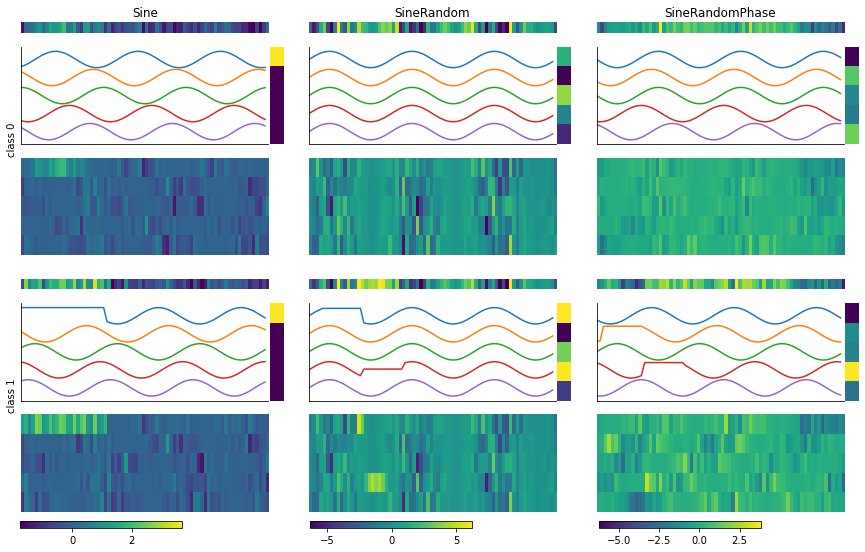

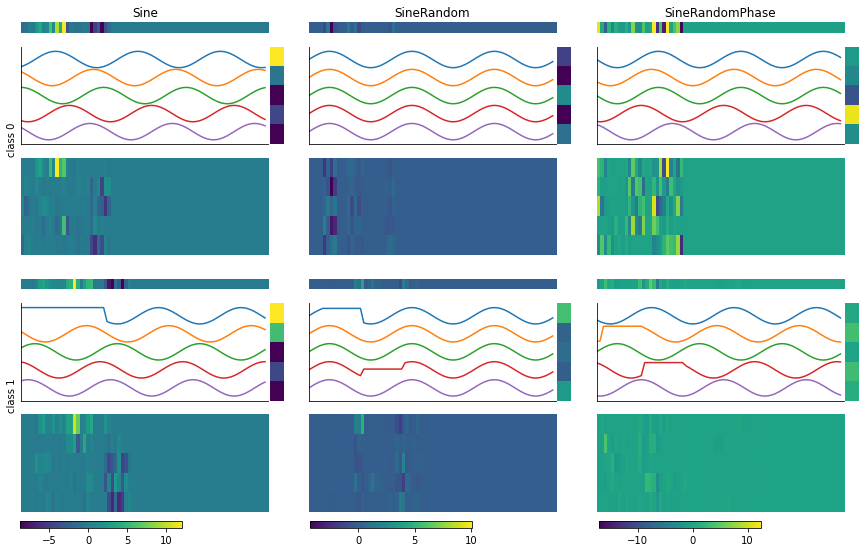

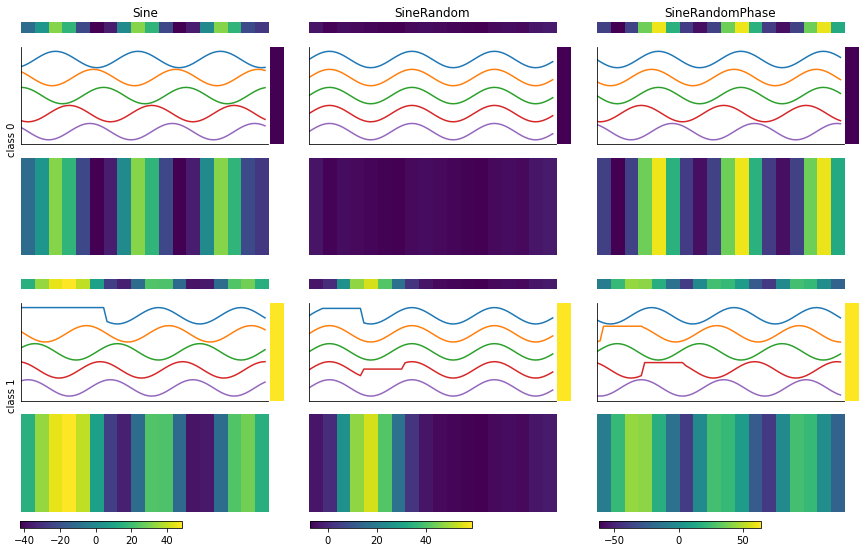

In [ ]:
# Visualization of the obtained explanations with LLM
from itertools import product

datasets = ['helix_1_start','helix_matching_random_amp_feat_time_no_phase','helix_matching_random_amp_feat_time'] #'circles','moons','helix_1_start','helix_2_start','helix_1_random_time','helix_2_random_time','helix_random_feat_random_time','helix_matching_random_amp_feat_time', 'helix_matching_random_amp_feat_time_no_phase'
DATASET_LABELS = {'helix_1_start':"Sine",'helix_matching_random_amp_feat_time_no_phase':"SineRandom",'helix_matching_random_amp_feat_time':"SineRandomPhase","blink_EEG":"Blink EEG"}
MODELS_LABELS  = {'relu-mlp':'MLP LLM','conv-relu-mlp':'LICOR','CAM-conv':'CNN CAM'} 
#model = 'conv-relu-mlp' # 'conv-relu-mlp' 'relu-mlp' 'CAM-conv'

for model in MODELS_LABELS.keys():
    fig = plt.figure(f"Model {MODELS_LABELS[model]} ",figsize=(15,9))
    n_ = len(CLSS)
    l = len(datasets)
    colorbars = []  
    print(f"Model {MODELS_LABELS[model]} ")
    gs = fig.add_gridspec(n_, l,wspace=0.1,hspace=0.1)

    for gg, (clss, dataset) in enumerate(product(CLSS, datasets)):
        
        x = EXPLS[model][dataset][clss][0]
        expl = EXPLS[model][dataset][clss][1]
        z_range = EXPLS[model][dataset]['z_range']
        axs = gs[gg].subgridspec(3,2,width_ratios=[0.95,0.05],height_ratios=[0.05,0.45,0.45],wspace=0.01)
        #Class label
        if gg%len(datasets)==0:
            ax_ = gs[gg].subgridspec(1,1)
            ax_ =fig.add_subplot(ax_[0,0],frameon=False)
            ax_.set_ylabel(f"class {clss}")
            ax_.set_xticks([])
            ax_.set_yticks([])
            
        # time steps  z-terms 
        ax= fig.add_subplot(axs[0,0])
        ax.set_xticks([])
        ax.set_yticks([]) 
        [spine.set_visible(False) for _,spine in ax.spines.items()]
        ax.imshow(np.sum(expl.T,axis=0,keepdims=True),cmap='viridis',interpolation=None,aspect='auto',vmin=z_range[0],vmax=z_range[1])
        
        #Dataset label
        if gg<len(datasets):
            ax.set_title(f"{DATASET_LABELS[dataset]}")
        #ax.set_title(f"y: {y_test[idx]}      y_est: %1.3f"%y_test_[0,0])
        ax= fig.add_subplot(axs[1,0])
        [spine.set_visible(False) for _,spine in ax.spines.items() if _ in ['top','right']]
        ax.set_xticks([])
        ax.set_yticks([]) 
        max_ = np.max(x)
        max_l = x.shape[0]
        n = x.shape[-1]
        for i in range(n):
            ax.plot(x[...,i]+n*1.2*max_-i*max_*1.1)
            ax.set_xlim((0,max_l))

        # feat z-terms
        ax= fig.add_subplot(axs[1,1])
        ax.set_xticks([])
        ax.set_yticks([]) 
        [spine.set_visible(False) for _,spine in ax.spines.items()]
        im = ax.imshow(np.sum(expl.T,axis=1,keepdims=True),cmap='viridis',vmin=z_range[0],vmax=z_range[1],interpolation=None,aspect='auto')
        if gg<len(datasets):
            colorbars.append(im)
        # Z-terms
        ax= fig.add_subplot(axs[2,0])
        [spine.set_visible(False) for _,spine in ax.spines.items()]
        ax.set_xticks([])
        ax.set_yticks([]) 
        im = ax.imshow(expl.T,cmap='viridis',interpolation=None,aspect='auto',vmin=z_range[0],vmax=z_range[1])
        

    for col_i, col in enumerate(colorbars):
        cax = plt.axes([0.124+0.268*col_i,0.1,0.15,0.01])
        plt.colorbar(col,orientation='horizontal',cax=cax)


In [ ]:
# AUC table
import pandas as pd
testAUC = []
datasets = ['helix_1_start','helix_matching_random_amp_feat_time_no_phase','helix_matching_random_amp_feat_time','blink_EEG']
for ii, (model, dataset) in enumerate(product(models, datasets)):
    print(f"item {ii} model {model} dataset {dataset}")
    testAUC.append(EXPLS[model][dataset]["test_auc"])
testAUC = np.array(testAUC).reshape((-1,len(datasets)))
df_testAUC = pd.DataFrame(testAUC,index=[MODELS_LABELS[m] for m in models],columns=[DATASET_LABELS[d] for d in datasets])
print(df_testAUC.to_latex(float_format='%1.3f'))

item 0 model CAM-conv dataset helix_1_start
item 1 model CAM-conv dataset helix_matching_random_amp_feat_time_no_phase
item 2 model CAM-conv dataset helix_matching_random_amp_feat_time
item 3 model CAM-conv dataset blink_EEG
item 4 model conv-relu-mlp dataset helix_1_start
item 5 model conv-relu-mlp dataset helix_matching_random_amp_feat_time_no_phase
item 6 model conv-relu-mlp dataset helix_matching_random_amp_feat_time
item 7 model conv-relu-mlp dataset blink_EEG
item 8 model relu-mlp dataset helix_1_start
item 9 model relu-mlp dataset helix_matching_random_amp_feat_time_no_phase
item 10 model relu-mlp dataset helix_matching_random_amp_feat_time
item 11 model relu-mlp dataset blink_EEG
\begin{tabular}{lrrrr}
\toprule
{} &  Sine &  SineRandom &  SineRandomPhase &  Blink EEG \\
\midrule
CNN CAM & 1.000 &       1.000 &            0.985 &      1.000 \\
LICOR   & 1.000 &       1.000 &            1.000 &      1.000 \\
MLP LLM & 1.000 &       1.000 &            0.805 &      1.000 \\
\bottom

/tmp/ipykernel_16268/1654916186.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_testAUC.to_latex(float_format='%1.3f'))


# Explanations for real data
A EEG data (https://github.com/Kelvin9811/EEG-Blink-dataset) measured from people blinking. The three models have been compared on the real dataset, obtaining the explanations shown below

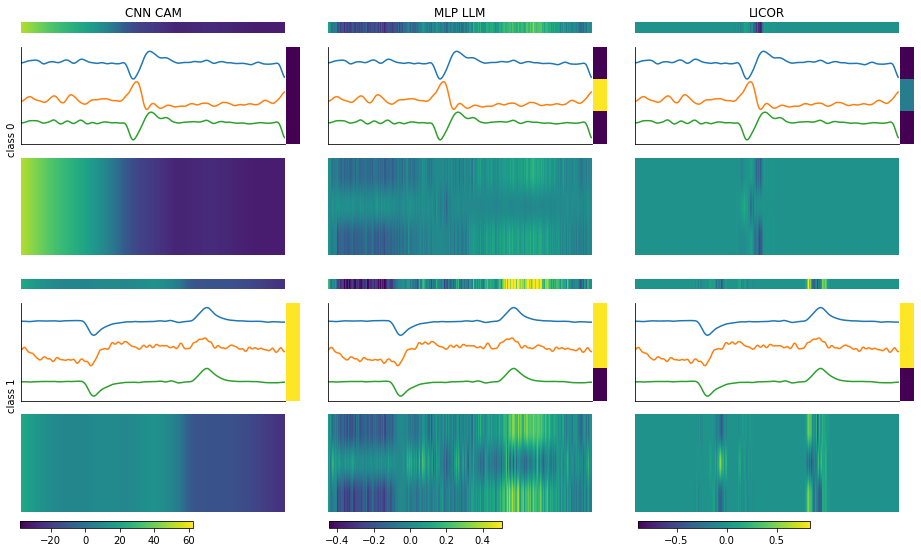

In [ ]:
# Blink dataset figure
dataset = 'blink_EEG'
MODELS_LABELS  = {'relu-mlp':'MLP LLM','conv-relu-mlp':'LICOR','CAM-conv':'CNN CAM'} 
fig = plt.figure(figsize=(16,9))
n_ = len(CLSS) #rows
l = len(models)  #columns
colorbars = []  

models = ['CAM-conv','relu-mlp','conv-relu-mlp']
#print(f"Model {MODELS_LABELS[model]} ")
gs = fig.add_gridspec(n_, l,wspace=0.1,hspace=0.1)
for gg, (clss, model) in enumerate(product(CLSS, models)):
    
    x = EXPLS[model][dataset][clss][0]
    expl = EXPLS[model][dataset][clss][1]
    z_range = EXPLS[model][dataset]['z_range']
    axs = gs[gg].subgridspec(3,2,width_ratios=[0.95,0.05],height_ratios=[0.05,0.45,0.45],wspace=0.01)
    #Class label
    if gg%len(models)==0:
        ax_ = gs[gg].subgridspec(1,1)
        ax_ =fig.add_subplot(ax_[0,0],frameon=False)
        ax_.set_ylabel(f"class {clss}")
        ax_.set_xticks([])
        ax_.set_yticks([])
        
    # time steps  z-terms 
    ax= fig.add_subplot(axs[0,0])
    ax.set_xticks([])
    ax.set_yticks([]) 
    [spine.set_visible(False) for _,spine in ax.spines.items()]
    ax.imshow(np.sum(expl.T,axis=0,keepdims=True),cmap='viridis',interpolation=None,aspect='auto',vmin=z_range[0],vmax=z_range[1])
    
    #Dataset label
    if gg<l:
        ax.set_title(f"{MODELS_LABELS[model]}")
    #ax.set_title(f"y: {y_test[idx]}      y_est: %1.3f"%y_test_[0,0])
    ax= fig.add_subplot(axs[1,0])
    [spine.set_visible(False) for _,spine in ax.spines.items() if _ in ['top','right']]
    ax.set_xticks([])
    ax.set_yticks([]) 
    max_ = np.max(x)
    max_l = x.shape[0]
    n = x.shape[-1]
    for i in range(n):
        ax.plot(x[...,i]+n*1.2*max_-i*max_*1.1)
        ax.set_xlim((0,max_l))

    # feat z-terms
    ax= fig.add_subplot(axs[1,1])
    ax.set_xticks([])
    ax.set_yticks([]) 
    [spine.set_visible(False) for _,spine in ax.spines.items()]
    im = ax.imshow(np.sum(expl.T,axis=1,keepdims=True),cmap='viridis',vmin=z_range[0],vmax=z_range[1],interpolation=None,aspect='auto')
    if gg<l:
        colorbars.append(im)
    # Z-terms
    ax= fig.add_subplot(axs[2,0])
    [spine.set_visible(False) for _,spine in ax.spines.items()]
    ax.set_xticks([])
    ax.set_yticks([]) 
    im = ax.imshow(expl.T,cmap='viridis',interpolation=None,aspect='auto',vmin=z_range[0],vmax=z_range[1])
    

for col_i, col in enumerate(colorbars):
    cax = plt.axes([0.124+0.268*col_i,0.1,0.15,0.01])
    plt.colorbar(col,orientation='horizontal',cax=cax)


# AUC using k-fold to increase the quality of the measure
5 folds are set to compute the AUC per model and dataset. The obtained metrics are shown in a latex table:

In [ ]:
import copy
from sklearn.model_selection import StratifiedKFold
AUC_METRICS = []
N_splits = 5
datasets = ['helix_1_start','helix_matching_random_amp_feat_time_no_phase','helix_matching_random_amp_feat_time','blink_EEG'] #'circles','moons','helix_1_start','helix_2_start','helix_1_random_time','helix_2_random_time','helix_random_feat_random_time','helix_matching_random_amp_feat_time', 'helix_matching_random_amp_feat_time_no_phase'
models = ['CAM-conv','conv-relu-mlp','relu-mlp'] # 'relu-mlp', 'conv-relu-mlp', 'CAM-conv'
for i, model_str in enumerate(models):
    for ii, data_str in enumerate(datasets):
        data = Dataset(data_str, train_fraction, seed_int)
        X_train,y_train =copy.deepcopy(data.train), copy.deepcopy(data.train_target)
        X_test,y_test =copy.deepcopy(data.test), copy.deepcopy(data.test_target)
        X = np.vstack([X_train,X_test])
        y = np.hstack([y_train,y_test])

        skf = StratifiedKFold(n_splits=N_splits)
        for k, (train_index, test_index) in enumerate(skf.split(X, y)):
            data.train,data.train_target = X[train_index],y[train_index]
            data.test, data.test_target  = X[test_index],y[test_index]
            model = Model(seed_int, data, model_str)
            _,test_auc = model.train_model()
            AUC_METRICS.append([MODELS_LABELS[model_str],DATASET_LABELS[data_str],test_auc])



        



Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 72, 1, 5)]        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 72, 1, 16)         256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 1, 16)         0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 36, 1, 32)         1568      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 18, 1, 32)         0         
_________________________________________________________________
ConvOutput (Conv2D)          (None, 18, 1, 64)         6208      
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)                0  

In [ ]:
df_aucMetrics = pd.DataFrame(AUC_METRICS,columns=["Model","Dataset","AUC"])
df_aucMetrics
table_metrics =df_aucMetrics.pivot_table(index='Model',columns='Dataset',values='AUC',aggfunc=np.mean)
table_metrics = table_metrics[[DATASET_LABELS[d] for d in datasets]]
print(table_metrics.to_latex(float_format='%1.4f'))
#df_aucMetrics.pivot_table(index='Model',columns='Dataset',values='AUC',aggfunc=np.std)


\begin{tabular}{lrrrr}
\toprule
Dataset &   Sine &  SineRandom &  SineRandomPhase &  Blink EEG \\
Model   &        &             &                  &            \\
\midrule
CNN CAM & 1.0000 &      1.0000 &           0.9902 &     0.9999 \\
LICOR   & 1.0000 &      1.0000 &           0.9999 &     0.9999 \\
MLP LLM & 1.0000 &      1.0000 &           0.8896 &     0.9970 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_16268/568922924.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_metrics.to_latex(float_format='%1.4f'))


In [ ]:
AUC_METRICS

[['CNN CAM', 'Sine', 1.0],
 ['CNN CAM', 'Sine', 1.0],
 ['CNN CAM', 'Sine', 1.0],
 ['CNN CAM', 'Sine', 1.0],
 ['CNN CAM', 'Sine', 1.0],
 ['CNN CAM', 'SineRandom', 1.0],
 ['CNN CAM', 'SineRandom', 1.0],
 ['CNN CAM', 'SineRandom', 1.0],
 ['CNN CAM', 'SineRandom', 1.0],
 ['CNN CAM', 'SineRandom', 1.0],
 ['CNN CAM', 'SineRandomPhase', 0.9954765439033508],
 ['CNN CAM', 'SineRandomPhase', 0.9982999563217163],
 ['CNN CAM', 'SineRandomPhase', 0.9856724739074707],
 ['CNN CAM', 'SineRandomPhase', 0.9852920174598694],
 ['CNN CAM', 'SineRandomPhase', 0.9864124655723572],
 ['CNN CAM', 'Blink EEG', 0.9998989701271057],
 ['CNN CAM', 'Blink EEG', 0.9998990297317505],
 ['CNN CAM', 'Blink EEG', 1.0],
 ['CNN CAM', 'Blink EEG', 0.9995918869972229],
 ['CNN CAM', 'Blink EEG', 1.0],
 ['LICOR', 'Sine', 1.0],
 ['LICOR', 'Sine', 1.0],
 ['LICOR', 'Sine', 1.0],
 ['LICOR', 'Sine', 1.0],
 ['LICOR', 'Sine', 1.0],
 ['LICOR', 'SineRandom', 1.0],
 ['LICOR', 'SineRandom', 1.0],
 ['LICOR', 'SineRandom', 1.0],
 ['LICOR', '

: 